In [2060]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2061]:
from __future__ import division, print_function, absolute_import 

In [2062]:
df = pd.read_csv('autoencoder.csv')
df

,Bedrooms,Bathrooms,Size,neignbourhood
0,2,2,950,0.742926
1,3,3,1299,0.714395
2,3,3,1200,0.954467
3,1,2,680,0.742926
4,2,2,890,0.742926
5,3,2,1100,0.714395
6,3,2,1299,0.714395
7,3,3,1400,0.954467
8,2,2,810,0.954467
9,2,2,800,0.954467


In [2063]:
bed = list(df.as_matrix()[:,0])
bath = list(df.as_matrix()[:,1])
sizes = list(df.as_matrix()[:,2])
print(max(sizes))
neigh = list(df.as_matrix()[:,3])

1599.0


In [2064]:
def get_data(path):
    df = pd.read_csv(path)
    matrix_df = df.as_matrix()
    mat = matrix_df[:,:]
    where_are_NaNs = np.isnan(mat)
    mat[where_are_NaNs] = 0
    maximums = np.amax(mat, axis=0)
    print(maximums)
    mat = mat/maximums
    return mat 

In [2065]:
mat = get_data("autoencoder.csv")
print(mat[:5])

[  4.00000000e+00   4.00000000e+00   1.59900000e+03   9.57845750e-01]
[[ 0.5         0.5         0.59412133  0.77562173]
 [ 0.75        0.75        0.81238274  0.74583548]
 [ 0.75        0.75        0.75046904  0.99647268]
 [ 0.25        0.5         0.42526579  0.77562173]
 [ 0.5         0.5         0.55659787  0.77562173]]


In [2066]:
def next_batch(mat, index, size):
    if index + size <= mat.shape[0]:
        return index+size, mat[index:index+size]
    else:
        return index+size-mat.shape[0], np.concatenate((mat[index:], mat[:index+size-mat.shape[0]]), axis=0)

In [2067]:
learning_rate = 0.0001
training_epochs = 800
batch_size = 50
display_step = 100
examples_to_show = 10
index = 0

In [2068]:
n_hidden_1 = 8
n_hidden_2 = 4
n_hidden_3 = 1
n_input = 4

In [2069]:
X = tf.placeholder("float", [None, n_input])

In [2070]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input]))
}

In [2071]:
bed_weights = weights['encoder_h1'][0]
bath_weights = weights['encoder_h1'][1]
size_weights = weights['encoder_h1'][2]
neigh_weights = weights['encoder_h1'][3]

In [2072]:
bed_penalty = 0
bath_penalty = 25
size_penalty = 0
neigh_penalty = 5

In [2073]:
def encoder(x):
    layer_1 = tf.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    layer_3 = tf.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    return layer_3

def decoder(x):
    layer_1 = tf.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    layer_3 = tf.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']), biases['decoder_b3']))
    return layer_3

In [2074]:
# Construct model 
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

In [2075]:
# Prediction 
y_pred = decoder_op 
y_true = X

In [2076]:
# loss and optimizer 
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2)) + bed_penalty*tf.reduce_sum(tf.abs(bed_weights)) + bath_penalty*tf.reduce_sum(tf.abs(bath_weights))
+ neigh_penalty*tf.reduce_sum(tf.abs(neigh_weights)) + size_penalty*tf.reduce_sum(tf.abs(size_weights))

optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [2077]:
init = tf.global_variables_initializer()

Epoch: 0001 cost= 120.703521729
Epoch: 0101 cost= 42.946220398
Epoch: 0201 cost= 18.826467514
Epoch: 0301 cost= 1.319771409
Epoch: 0401 cost= 0.041494042
Epoch: 0501 cost= 0.042451732
Epoch: 0601 cost= 0.031639550
Epoch: 0701 cost= 0.025094729
Optimization Finished!


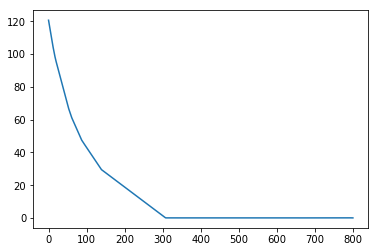

In [2078]:
with tf.Session() as sess:
    sess.run(init)
    total_c = []
    total_batch = int(mat.shape[0]/batch_size)
    
    for epoch in range(training_epochs):
        for i in range(total_batch):
            index, batch_xs = next_batch(mat, index, batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
         
        total_c.append(c)
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(c))
    print("Optimization Finished!")
    
    score = sess.run(encoder_op, feed_dict={X: mat})
    scores = list(score)

plt.plot(total_c)

1599.0


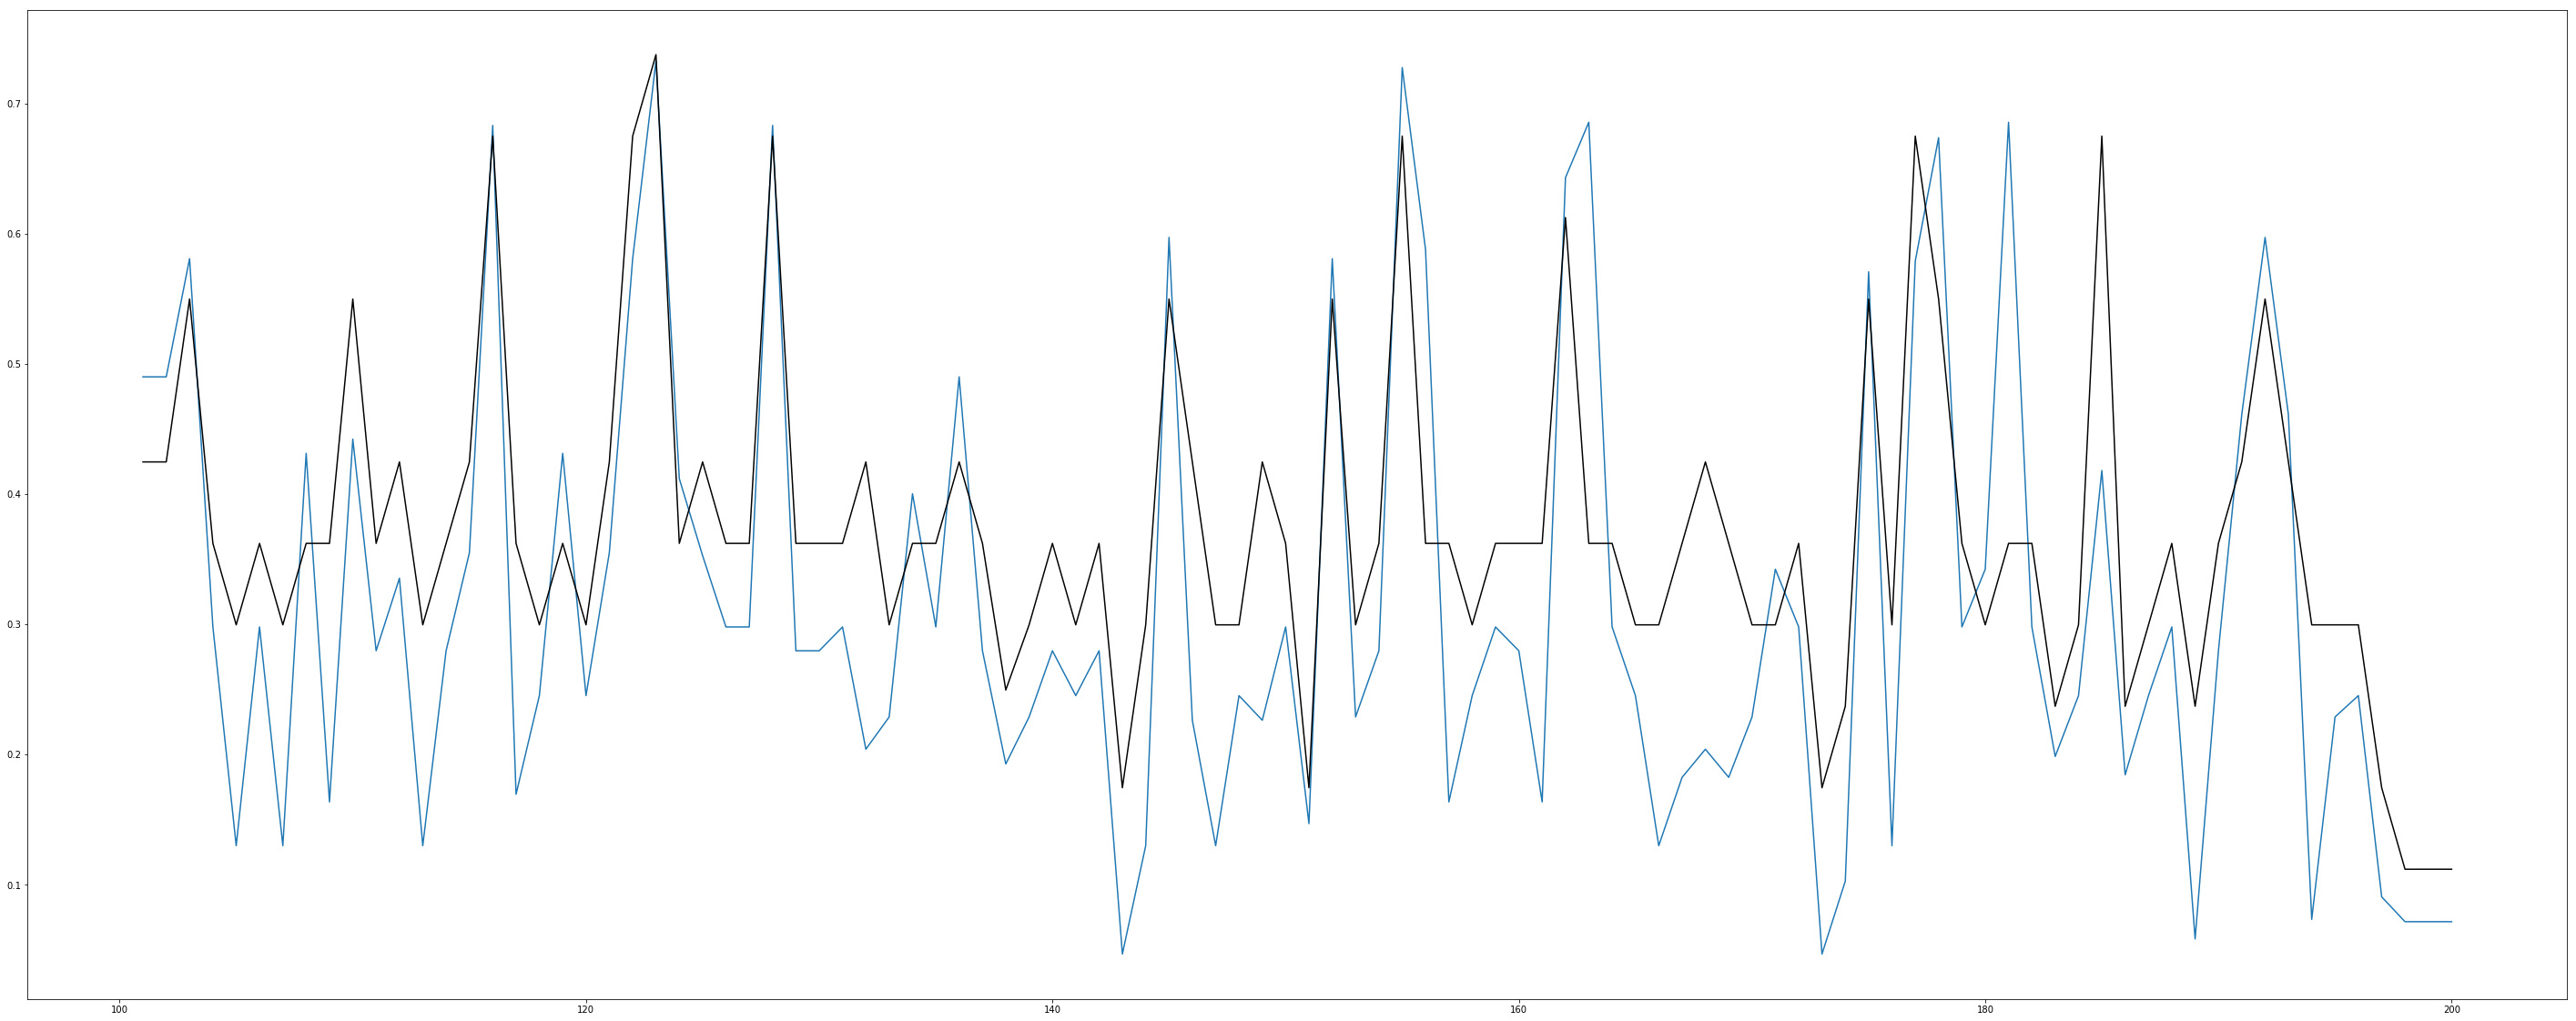

In [2079]:
x_line = range(1,mat.shape[0]+1)
plt.figure(figsize=(50, 20))
size_max = max(sizes)
print(size_max)
bed_max = max(bed)
bath_max = max(bath)
neigh_max = max(neigh)
plt.plot(x_line[100:200], scores[100:200], x_line[100:200], [com/size_max-0.2 for com in sizes][100:200], 'k')

In [1813]:
print(scores)

[array([ 0.67468542], dtype=float32), array([ 0.84577817], dtype=float32), array([ 0.86712921], dtype=float32), array([ 0.33149853], dtype=float32), array([ 0.6470015], dtype=float32), array([ 0.81339771], dtype=float32), array([ 0.84577918], dtype=float32), array([ 0.88197434], dtype=float32), array([ 0.72018093], dtype=float32), array([ 0.71653831], dtype=float32), array([ 0.88191277], dtype=float32), array([ 0.27327493], dtype=float32), array([ 0.6470015], dtype=float32), array([ 0.8751632], dtype=float32), array([ 0.5563153], dtype=float32), array([ 0.74716586], dtype=float32), array([ 0.63724148], dtype=float32), array([ 0.83134657], dtype=float32), array([ 0.87523699], dtype=float32), array([ 0.84577817], dtype=float32), array([ 0.63724148], dtype=float32), array([ 0.86704075], dtype=float32), array([ 0.6005401], dtype=float32), array([ 0.25585172], dtype=float32), array([ 0.6005401], dtype=float32), array([ 0.77819425], dtype=float32), array([ 0.58064687], dtype=float32), array(

In [1814]:
def save_to_csv(df, path):
    df.to_csv(path)
def convert_to_dataframe(mat):
    return pd.DataFrame(data=mat)
new = convert_to_dataframe(scores)
save_to_csv(new, 'new_scores.csv')